# **Market Basket Analysis with Apriori Algorithm**

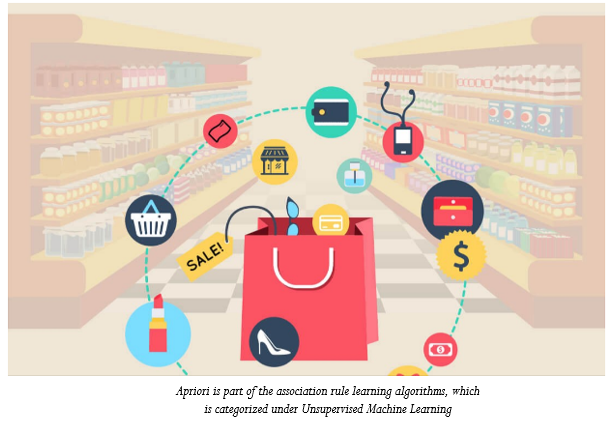

# **Association Rule Learning (ARL)**

In today's world where the number of customers and transactions are increasing, it has become more valuable to create meaningful results from data and for developing marketing strategies. Revealing hidden patterns in the data in order to be able to compete better and maximize profit in the face of intense competition in the market, and to establish value-oriented long-term relationships with customers, makes a great contribution to determining marketing strategies. 

However, the development of rule-based strategies is no longer possible in big data world, offering the right product to the right customer at the right time; it forms the basis of cross-selling and loyalty programs within the scope of customer retention and increasing lifetime value. Therefore, it has been crucial point for companies making product offers by using these patterns of association and developing effective marketing strategies Market Basket analysis is one of the association rule applications. It allows us to predict the products that customers tend to buy in the future by developing a pattern from their past behavior and habits. 

There are different algorithms to be used for Association Rules Learning. One of them is the Apriori algorithm. In this project, product association analysis will be handled with **“Apriori Algorithm”** and the most suitable product offers will be made for the customer who is in the sales process, using the sales data of an e-commerce company.

# **Dataset Story:**

• The Online Retail II data set, which includes the sales data of the UK-based online sales store, was used.

• Sales data between 01/12/2009 - 09/12/2011 are included in the data set.

• The product catalog of this company includes souvenirs.

# **Business Problem:**

Suggesting products to users at the basket stage. In this study, we will apply Market Basket analysis using the Apriori algorithm. In this context, we will consider the work in 5 steps:

**1.** Import Data & Data Preprocessing

**2.** Preparing Invoice-Product Matrix fot ARL Data Structure  

**3.** Determination of Association Rules

**4.** Suggesting appropriate product offers to customers at the basket stage 

**5.** Functionalization 
 

# **Variables Descriptions:**

• InvoiceNo: Invoice Number -> If this code starts with C, it means that the operation has been canceled.

• StockCode: Product Code -> Unique number for each product

• Description: Product name

• Quantity: Number of products -> how many of the products on the invoices were sold.

• InvoiceDate

• UnitePrice

• CustomerID: Unique customer number

• Country

In [1]:
# Import Libraries

import pandas as pd

# For Association Rules Learning & Apriori 
# !pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

# Setting Configurations:

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Import Warnings:

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# 1. Import Data & Data Preprocessing

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 4.3 MB/s            


In [3]:
df_ = pd.read_excel('../input/online-retail-dataset/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = df_.copy()

In [4]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00  2.550    17850.000  United Kingdom  
1 2010-12-01 08:26:00  3.390    17850.000  United Kingdom  
2 2010-12-01 08:26:00  2.750    17850.000  United Kingdom  
3 2010-12-01 08:26:00  3.390    17850.000  United Kingdom  
4 2010-12-01 08:26:00  3.390    17850.000  United Kingdom

In [5]:
## Data Preprocessing

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.isna().sum() 

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.shape

(406830, 8)

In [9]:
df.describe().T

count      mean      std        min       25%       50%  \
Quantity    406830.000    12.061  248.693 -80995.000     2.000     5.000   
Price       406830.000     3.461   69.315      0.000     1.250     1.950   
Customer ID 406830.000 15287.684 1713.603  12346.000 13953.000 15152.000   

                  75%       max  
Quantity       12.000 80995.000  
Price           3.750 38970.000  
Customer ID 16791.000 18287.000

In [10]:
# Let's first determine cancelled transactions (Invoice Id contains value "C") and then remove them:

df_Invoice = pd.DataFrame({"Invoice":[row for row in df["Invoice"].values if "C"  not in str(row)]})
df_Invoice.head()
df_Invoice = df_Invoice.drop_duplicates("Invoice")


In [11]:
# The transactions except cancelled transactions:
df = df.merge(df_Invoice, on = "Invoice")


In [12]:
# Outlier Detection:


# Outlier değerler için baskılama yapılacak low ve up limit belirleyelim:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# Replace outliers with thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
  

In [13]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [14]:
num_cols = [col for col in df.columns if df[col].dtypes in ["int64","float64"] and "ID" not in col]

print(num_cols)

['Quantity', 'Price']


In [15]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [16]:
df.describe().T

count      mean      std       min       25%       50%  \
Quantity    397925.000    11.834   25.534     1.000     2.000     6.000   
Price       397925.000     2.893    3.227     0.000     1.250     1.950   
Customer ID 397925.000 15294.309 1713.173 12346.000 13969.000 15159.000   

                  75%       max  
Quantity       12.000   298.500  
Price           3.750    37.060  
Customer ID 16795.000 18287.000

In [17]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [18]:
# Unique Number of Products (with Description)

df.Description.nunique()

3877

In [19]:
# Unique Number of Products (with StockCode)

df.StockCode.nunique()

3665

The unique values of these 2 variables (Description & StockCode) should be equal, because each stock code represents a product:

In [20]:
# 1st Step
df_product = df[["Description","StockCode"]].drop_duplicates()
df_product = df_product.groupby(["Description"]).agg({"StockCode":"count"}).reset_index()
df_product.sort_values("StockCode", ascending=False).head()

Description  StockCode
2014   METAL SIGN,CUPCAKE SINGLE HOOK          3
2471       PINK FLOWERS RABBIT EASTER          2
1077  EAU DE NILE JEWELLED PHOTOFRAME          2
2460    PINK FAIRY CAKE CUSHION COVER          2
3678      WHITE BAMBOO RIBS LAMPSHADE          2

In [21]:
df_product.rename(columns={'StockCode':'StockCode_Count'},inplace=True)

df_product = df_product[df_product["StockCode_Count"]>1]

Let's delete products with more than one stock code:

In [22]:
df = df[~df["Description"].isin(df_product["Description"])]

In [23]:
print(df.StockCode.nunique())
print(df.Description.nunique())

3630
3858


In [24]:
# 2nd Step
df_product = df[["Description","StockCode"]].drop_duplicates()
df_product = df_product.groupby(["StockCode"]).agg({"Description":"count"}).reset_index()
df_product.rename(columns={'Description':'Description_Count'},inplace=True)

In [25]:
df_product = df_product.sort_values("Description_Count", ascending=False)
df_product.head()

StockCode  Description_Count
1990     23236                  4
1950     23196                  4
2104     23366                  3
1886     23131                  3
1994     23240                  3

In [26]:
df_product = df_product[df_product["Description_Count"] > 1] 

df_product.head()

StockCode  Description_Count
1990     23236                  4
1950     23196                  4
2104     23366                  3
1886     23131                  3
1994     23240                  3

Let's delete stock codes that represent multiple products:

In [27]:
df = df[~df["StockCode"].isin(df_product["StockCode"])]

In [28]:
# Now each stock code represents a single product:

print(df.StockCode.nunique())
print(df.Description.nunique())

3420
3420


The post statement in the stock code shows the postage cost, let's delete it as it is not a product:

In [29]:
df = df[~df["StockCode"].str.contains("POST", na=False)]

We'll handle sales data of Germany as an example:  

In [30]:
df_germany = df[df["Country"] == "Germany"]
df_germany.shape

(7843, 8)

# 2.Preparing Invoice-Product Matrix fot ARL Data Structure

In [31]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [32]:
gr_inv_pro_df = create_invoice_product_df(df_germany, id=True)
gr_inv_pro_df.head()

StockCode  10002  10125  11001  15034  15036  15039  16008  16011  16014  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  16016  16045  16054  16218  16235  16236  16237  16238  16259  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         1      0      0      0      0      0      0      0      0   

StockCode  17003  20652  20658  20665  20668  20674  20675  20676  20677  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  20679  20681  20682  20684  20685  20696  20702  20704  20705  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  20707  20711  20712  20713  20716  20717  20718  20719  20723  \
Invoice                                                                    
536527         0      0      1      1      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  20724  20726  20727  20728  20749  20750  20751  20752  20754  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  20755  20761  20766  20767  20772  20774  20794  20796  20828  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  20846  20897  20902  20903  20961  20963  20971  20972  20973  \
Invoice                                                                    
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0    

In [33]:

# Let's define a function to find the product name corresponding to the stock code:

def check_id(dataframe, stockcode):
    product_name = dataframe[dataframe["StockCode"] == stockcode]["Description"].unique()[0]
    return stockcode, product_name

In [34]:
check_id(df_germany, 10002)

(10002, 'INFLATABLE POLITICAL GLOBE ')

In [35]:
check_id(df_germany, 47480)

(47480, 'HANGING PHOTO CLIP ROPE LADDER')

In [36]:
check_id(df_germany, 22977)

(22977, 'DOLLY GIRL CHILDRENS EGG CUP')

# 3. Determination of Association Rules

Calculate the support values for every possible configuration of items (thereshold of support has been chosen 0.01 (1%))


In [37]:
frequent_itemsets = apriori(gr_inv_pro_df, min_support=0.01, use_colnames=True)

In [38]:
frequent_itemsets.head()

support itemsets
0    0.013  (10125)
1    0.020  (15036)
2    0.011  (16016)
3    0.016  (16045)
4    0.011  (16235)

In [39]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)

rules.sort_values("support", ascending=False).head(5)


antecedents consequents  antecedent support  consequent support  support  \
1862     (22328)     (22326)               0.162               0.252    0.135   
1863     (22326)     (22328)               0.252               0.162    0.135   
1912     (22554)     (22326)               0.142               0.252    0.076   
1913     (22326)     (22554)               0.252               0.142    0.076   
1931     (22326)     (22629)               0.252               0.106    0.072   

      confidence  lift  leverage  conviction  
1862       0.833 3.311     0.094       4.490  
1863       0.536 3.311     0.094       1.805  
1912       0.540 2.144     0.041       1.626  
1913       0.304 2.144     0.041       1.233  
1931       0.286 2.705     0.045       1.252

Let's explain the metrics we see in the table above:

* **antecedent support:** If X is called antecendent,  'antecedent support' computes the proportion of transactions that contain the antecedent X.
* **consequent support:** If Y is called consequent,  'consequent support' computes the proportion of transactions that contain the antecedent Y.
* **support:** 'support' computes the proportion of transactions that contain the antecedent X and Y.
* **confidence:** Probability of buying Y when X is bought.
* **lift:** Represents how many times the probability of getting Y increases when X is received.

Let's sort dataframe by lift:

In [40]:
sorted_rules = rules.sort_values("lift", ascending=False)

# 4.Suggesting a Product to Users at the Basket Stage

We can develop different strategies at the product offer stage. 

For example, When X is bought, we can sort according to the probability of buying Y (confidence) and make a product offer, or we can make an offer according to how many times the probability of sales over the lift increases. We can also make a product recommendation with a hybrid filtering where support, lift and confidence are used together. 


***If user buys a product whose id is 22492, which products do you recommend?***

In [41]:
product_id = 22492

check_id(df, product_id)

(22492, 'MINI PAINT SET VINTAGE ')

**First, define a function for recommending a product:**

In [42]:
product_id = 22554
recommendation_list = []


for idx, product in enumerate(sorted_rules["antecedents"]):
    # antecendent tuple olduğu için listeye çevirelim ve liste içinde arayalım:
    for j in list(product):
        if j == product_id:
            # bu yakaladığımız integer değerin indexi ne ise (idx) consequentte onu arayacağız, bulduğumuz satırlar için ilk ürünü [0]  önerelim 
            recommendation_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
            recommendation_list = list( dict.fromkeys(recommendation_list) )

***Let's bring the top 5 most preferred products together with the product with id 22492.***

In [43]:
list_top5 = recommendation_list[0:5]
list_top5

[21086, 21094, 22728, 21731, 21672]

In [44]:
# Let's show the product names of top 5 recommended products:

for elem in list_top5:
    print(check_id(df_germany,elem))

(21086, 'SET/6 RED SPOTTY PAPER CUPS')
(21094, 'SET/6 RED SPOTTY PAPER PLATES')
(22728, 'ALARM CLOCK BAKELIKE PINK')
(21731, 'RED TOADSTOOL LED NIGHT LIGHT')
(21672, 'WHITE SPOT RED CERAMIC DRAWER KNOB')


***What is next?***

Each product and related products can be stored at the database level and an integrated structure can be established with the purchasing processes. Thus, while a customer is purchasing product A, the first 3 products related to this product can be offered as an offer by calling the relevant product from the database. 



# 6. FUNCTIONALIZATION:

In [45]:
# Import & Filter Data:

def data_filter(dataframe, country=False, Country=""):
    if country:
        dataframe = dataframe[dataframe["Country"] == Country]
    return dataframe

In [46]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
def data_prep(dataframe):
    
    # Data preprocessing:
    dataframe.dropna(inplace=True)
    
    # Delete if the product name contains "POST":
    dataframe = dataframe[~dataframe["StockCode"].str.contains("POST", na=False)]
    
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe

 
# Invoice Product Matrix:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0) 
    
    
# Find Product name with Stock Code:

def check_id(dataframe, stockcode):
    product_name = dataframe[dataframe["StockCode"] == stockcode]["Description"].unique()[0]
    return stockcode, product_name


# Apriori Algorithm & ARL Rules:

def apriori_alg(dataframe, support_val=0.01):
    inv_pro_df = create_invoice_product_df(dataframe, id=True)
    frequent_itemsets = apriori(inv_pro_df, min_support=support_val, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=support_val)
    sorted_rules =  rules.sort_values("support", ascending=False) 
    return sorted_rules
    
    
  
         
def recommend_product(dataframe, product_id, support_val= 0.01, num_of_products=5):
    sorted_rules = apriori_alg(dataframe, support_val)
    recommendation_list = []  
    for idx, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
                recommendation_list = list( dict.fromkeys(recommendation_list) )
    return(recommendation_list[0:num_of_products])

In [47]:
# Data Preparation: 
df = df_.copy()

df = data_prep(df)
df = data_filter(df,country=True,Country="Germany")
df.head()

Invoice StockCode                          Description  Quantity  \
1109  536527     22809              SET OF 6 T-LIGHTS SANTA     6.000   
1110  536527     84347  ROTATING SILVER ANGELS T-LIGHT HLDR     6.000   
1111  536527     84945   MULTI COLOUR SILVER T-LIGHT HOLDER    12.000   
1112  536527     22242        5 HOOK HANGER MAGIC TOADSTOOL    12.000   
1113  536527     22244           3 HOOK HANGER MAGIC GARDEN    12.000   

             InvoiceDate  Price  Customer ID  Country  
1109 2010-12-01 13:04:00  2.950    12662.000  Germany  
1110 2010-12-01 13:04:00  2.550    12662.000  Germany  
1111 2010-12-01 13:04:00  0.850    12662.000  Germany  
1112 2010-12-01 13:04:00  1.650    12662.000  Germany  
1113 2010-12-01 13:04:00  1.950    12662.000  Germany

In [49]:
def recommendation_system_func(dataframe,support_val=0.01, num_of_products= 5 ):
    product_id = input("Enter a product id:")
    
    if product_id in list(dataframe["StockCode"].astype("str").unique()):
        product_list = recommend_product(dataframe, int(product_id), support_val, num_of_products)
        if len(product_list) == 0:
            print("There is no product can be recommended!")
        else:
            print("Related products with product id -" , product_id , "can be seen below:")
        
            for i in range(0, len(product_list[0:num_of_products])):
                print(check_id(dataframe, product_list[i]))
            
    else:
        print("Invalid Product Id, try again!")


In [51]:
# Enter product id - 1 (22326)

recommendation_system_func(df)

Enter a product id: 22326


Related products with product id - 22326 can be seen below:
(22328, 'ROUND SNACK BOXES SET OF 4 FRUITS ')
(22554, 'PLASTERS IN TIN WOODLAND ANIMALS')
(22629, 'SPACEBOY LUNCH BOX ')
(20719, 'WOODLAND CHARLOTTE BAG')
(22556, 'PLASTERS IN TIN CIRCUS PARADE ')


In [52]:
# Enter product id - 2 (22725)

recommendation_system_func(df)

Enter a product id: 22725


Related products with product id - 22725 can be seen below:
(22727, 'ALARM CLOCK BAKELIKE RED ')
(22326, 'ROUND SNACK BOXES SET OF4 WOODLAND ')
(22728, 'ALARM CLOCK BAKELIKE PINK')
(22726, 'ALARM CLOCK BAKELIKE GREEN')
(22729, 'ALARM CLOCK BAKELIKE ORANGE')


In [53]:
# Enter product id - 3 (22809)

recommendation_system_func(df)

Enter a product id: 22809


There is no product can be recommended!


In [54]:
# Enter product id - 4 (2256523)

recommendation_system_func(df)

Enter a product id: 2256523


Invalid Product Id, try again!
